In [2]:
%load_ext autoreload
%autoreload 2

import os
import sys

import numpy as np
import torch
import h5py
from ipywidgets import interact
import matplotlib.pyplot as plt

dir2 = os.path.abspath('..')
dir1 = os.path.dirname(dir2)
if not dir1 in sys.path: 
    sys.path.append(dir1)

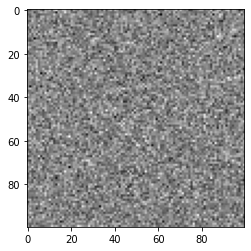

In [7]:
x = np.random.randn(100, 100)
plt.imshow(x, cmap='gray')

In [3]:
from pathlib import Path

dataset_path = Path("X:\\Datasets\\EEG\\Things-supplementary\\Inversions\\things_stimulus01_inverted.hdf5")
dataset = h5py.File(dataset_path, "r")

N = dataset['xtrain'].shape[0]
@interact(i=(0, N-1))
def show(i):
    img = dataset['xtrain'][i]
    img = np.moveaxis(img, 0, -1)
    
    label_id = dataset['ytrain'][i]
    
    print(classes[label_id])
    
    plt.imshow(img)

FileNotFoundError: [Errno 2] Unable to open file (unable to open file: name = 'X:\Datasets\EEG\Things-supplementary\Inversions\things_stimulus01_inverted.hdf5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)

In [4]:
from pathlib import Path
from research.imagenet_classes import classes

dataset_path = Path("G:\\Github Repositories\\exploiting-gan-internal-capacity\\inverses\\dataset.hdf5")
dataset = h5py.File(dataset_path, "r")

N = dataset['xtrain'].shape[0]
@interact(i=(0, N-1))
def show(i):
    img = dataset['xtrain'][i]
    img = np.moveaxis(img, 0, -1)
    
    label_id = dataset['ytrain'][i]
    
    print(classes[label_id])
    
    plt.imshow(img)

ImportError: cannot import name 'classes' from 'research.imagenet_classes' (G:\Github Repositories\Neurophysiological-Data-Decoding\research\imagenet_classes.py)

In [5]:
from research.things_dataset import ThingsDataset
from research.imagenet_classes import imagenet_classes
import torchvision.transforms as T
import torch.nn.functional as F

transform = T.Compose([
    T.Resize(224),
    T.ToTensor(),
])

things_dataset = ThingsDataset(
    root="X:\\Datasets\\EEG\\Things-concepts-and-images\\",
    transform=transform,
    supplementary_path="X:\\Datasets\\EEG\\Things-supplementary\\",
    latent_name="bigbigan-resnet50",
)


@interact(idx=(0, len(things_dataset) - 1))
def show(idx):
    image = things_dataset[idx]
    data = image['data']
    
    #x = T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])(data)
    #y_pred = resnext101_32x8d(x[None])
    #_, class_id = torch.max(y_pred, 1)
    #class_id = int(class_id)
    #print("predicted:", imagenet_classes[class_id])
    
    data = torch.moveaxis(data , 0, -1)
    plt.imshow(data)
    plt.show()

ModuleNotFoundError: No module named 'research.things_dataset'

In [ ]:
import torchvision.models as models
resnext101_32x8d = models.resnext101_32x8d(pretrained=True)
resnet152 = models.resnet152(pretrained=True)
resnet101 = models.resnet101(pretrained=True)
resnext101_32x8d.eval()
resnet152.eval()
resnet101.eval()
print()

In [ ]:
resnet152

In [ ]:
from torch.utils.data import DataLoader

model = resnet152
device = torch.device('cuda')

model = model.to(device)
dataloader = DataLoader(things_dataset, batch_size=8)
for batch in dataloader:
    data = batch['data']
    
    x = T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])(data)
    x = x.to(device)
    y_pred = model(x)
    
    break

In [ ]:
from dall_e import map_pixels, unmap_pixels, load_model

device = torch.device('cuda')

# For faster load times, download these files locally and use the local paths instead.
enc = load_model("X:\Models\dall-e\encoder.pkl", device)
dec = load_model("X:\Models\dall-e\decoder.pkl", device)

In [ ]:
import torch.nn.functional as F
from IPython.display import display, display_markdown

@interact(i=(0, len(things_dataset)-1))
def show(i):
    image = things_dataset[i]
    print(image['concept_name'])
    data = image['data']
    data = map_pixels(data[None])
    data = data.to(device)
    
    z_logits = enc(data)
    print(z_logits.shape)
    
    z = torch.argmax(z_logits, axis=1)
    z = F.one_hot(z, num_classes=enc.vocab_size).permute(0, 3, 1, 2).float()
    print(z.shape)

    x_stats = dec(z).float()
    x_rec = unmap_pixels(torch.sigmoid(x_stats[:, :3]))
    x_rec = T.ToPILImage(mode='RGB')(x_rec[0])

    display_markdown('Reconstructed image:')
    display(x_rec)

In [ ]:
import gensim.downloader as api
wv = api.load('word2vec-google-news-300')

In [ ]:
wn.synsets('yarn')

In [ ]:
concepts_missing_synsets = things_dataset.concepts[things_dataset.concepts['Wordnet ID4'].isnull()]

print(concepts_missing_synsets[["uniqueID",  "WordNet Synonyms"]])

In [2]:
from nltk.corpus import wordnet as wn
from research.imagenet_wordnet_ids import imagenet_wordnet_ids_raw


things_wordnet_ids = list(things_dataset.concepts['Wordnet ID4'])

things_synsets = [wn.synset(wordnet_id) if isinstance(wordnet_id, str) else None 
                  for wordnet_id in things_wordnet_ids]

imagenet_synsets = [
    wn.synset_from_pos_and_offset(wordnet_id[0], int(wordnet_id[1:]))
    for wordnet_id, _ in imagenet_wordnet_ids_raw.values()
]

similarity_matrix = np.zeros(shape=(len(imagenet_synsets), len(things_synsets)))
for i, imagenet_synset in enumerate(imagenet_synsets):
    if i % 50 == 0:
        print(i)
    for j, things_synset in enumerate(things_synsets):
        if imagenet_synset and things_synset:
            sim = imagenet_synset.path_similarity(things_synset)
            similarity_matrix[i, j] = sim

ModuleNotFoundError: No module named 'nltk'

In [ ]:
similarity_matrix.argsort()[:, :k]

In [ ]:
k = 5
k_args = similarity_matrix.argsort(axis=0)
print(k_args.shape)

for imagenet_synset, k_arg in zip(imagenet_synsets, list(k_args)):
    print(imagenet_synset, [things_synsets[arg] for arg in k_arg])
    continue

In [ ]:
#np.savetxt("imagenet_things_similarity_01.csv", similarity_matrix, delimiter=",")

In [ ]:
similarity_matrix = np.loadtxt("imagenet_things_similarity_01.csv", dtype=float, delimiter=",")

In [ ]:
print(similarity_matrix)

In [ ]:
import math

math.isnan(things_wordnet_ids[8])

In [ ]:
wn.synset("john.n.02")